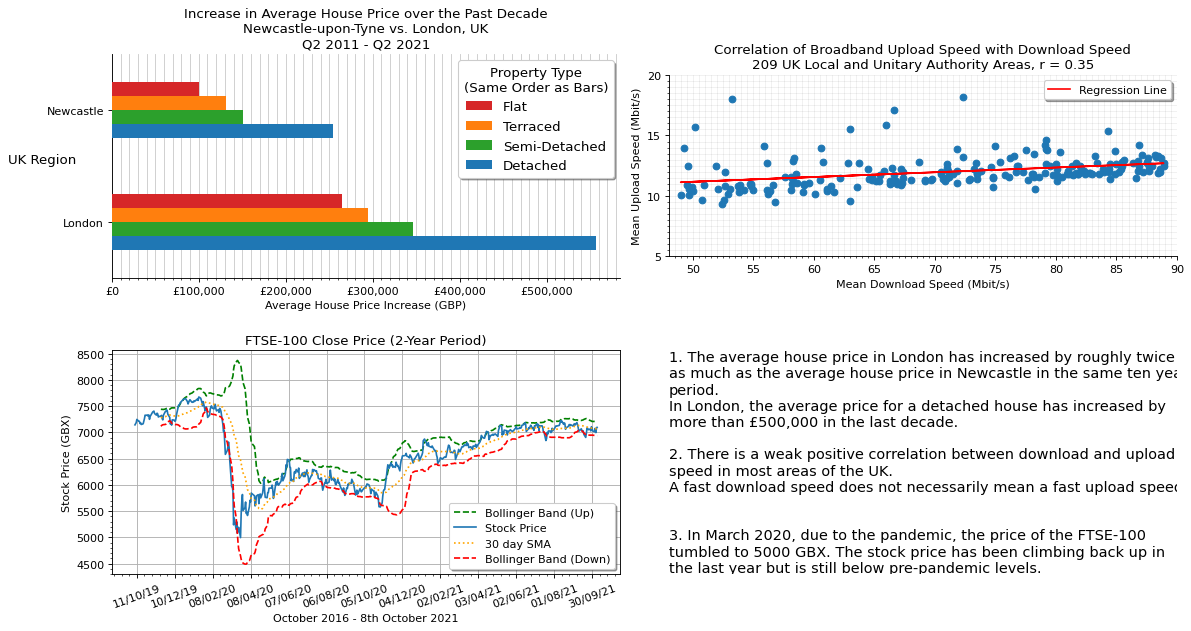

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
property_data = pd.read_csv("Average-prices-Property-Type-2021-05_wrangled.csv")
internet_data = pd.read_csv("202006_fixed_laua_performance_wrangled.csv")
ftse_data = pd.read_csv("ftse_data_wrangled.csv")

def wrangle_data(house_price_df, broadband_speed_df, ftse_data_df):
    house_price_df.query(
        'Date == \'2011-04-01\' | Date == \'2021-04-01\'', inplace=True)
    house_price_df.reset_index(inplace=True)
    house_price_df.drop('index', axis=1, inplace=True)
    house_price_df.rename(
        columns={"propertyType": "Property Type"}, inplace=True)
    house_price_df.loc[house_price_df.Region_Name ==
                       'Newcastle upon Tyne', 'Region_Name'] = 'Newcastle'
    house_price_df.loc[house_price_df['Property Type'] ==
                       'Semi_Detached', 'Property Type'] = 'Semi-Detached'

    decade_change = []
    for i in range(0, 14):
        decade_change.append(
            house_price_df['averagePrice'][i + 2] - house_price_df['averagePrice'][i])
    house_price_df['decadeChange'] = pd.Series(decade_change)
    house_price_df = house_price_df[house_price_df['decadeChange'] > 0].reset_index(
    )
    house_price_df['Date'] = '2011 - 2021'
    house_price_df.drop(columns=['index', 'averagePrice'])
    house_price_df = house_price_df.pivot(index='Region_Name',
                                          columns='Property Type', values='averagePrice')
    house_price_df.sort_values(
        by='London', axis=1, ascending=False, inplace=True)

    broadband_speed_df.drop(
        ['laua', 'medUpload', 'medDown'], axis=1, inplace=True)

    # Remove outliers
    broadband_speed_df = broadband_speed_df[(broadband_speed_df['averageDown'] < (broadband_speed_df['averageDown'].mean() + (broadband_speed_df['averageDown'].std()))) &
                                            (broadband_speed_df['averageDown'] > (broadband_speed_df['averageDown'].mean() - (broadband_speed_df['averageDown'].std())))]
    broadband_speed_df = broadband_speed_df[(broadband_speed_df['averageUpload'] < (broadband_speed_df['averageUpload'].mean() + (broadband_speed_df['averageUpload'].std()))) &
                                            (broadband_speed_df['averageUpload'] > (broadband_speed_df['averageUpload'].mean() - (broadband_speed_df['averageUpload'].std())))].reset_index()
    broadband_speed_df.drop('index', axis=1, inplace=True)

    ftse_data_df['date'] = pd.to_datetime(
        ftse_data_df['date'], format='%Y-%m-%d')
    ftse_data_df = ftse_data_df[(ftse_data_df['date'] >= '2019-10-08')
                                & (ftse_data_df['date'] <= '2021-10-08')].reset_index()
    ftse_data_df.drop(['index', 'Open', 'High', 'Low',
                       'Dividends', 'Stock Splits'], axis=1, inplace=True)
    return house_price_df, broadband_speed_df, ftse_data_df


def plot_data(house_price_df, broadband_speed_df, ftse_data_df):
    xValues = broadband_speed_df.averageDown
    yValues = broadband_speed_df.averageUpload
    r = broadband_speed_df['averageDown'].corr(
        broadband_speed_df['averageUpload'])

    gradient, intercept = np.polyfit(xValues, yValues, 1)

    interval = 30
    sma = ftse_data_df['Close'].rolling(interval).mean()
    std_dev = ftse_data_df['Close'].rolling(interval).std()
    bollinger_up = sma + std_dev * 2
    bollinger_down = sma - std_dev * 2

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
        2, 2, figsize=(24, 13.5), dpi=80)
    house_price_df.plot(kind='barh', figsize=(15, 8), ax=ax1, zorder=3, color=(
        '#1f77b4', '#2ca02c', '#ff7f0e', '#d62728'))
    ax1.xaxis.set_major_locator(MultipleLocator(100000))
    ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax1.xaxis.set_major_formatter('£{x:,.0f}')

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    ax1.grid(which='both', axis='x', color='black',
             alpha=0.2, linewidth=0.8, zorder=0, linestyle='-')
    ax1.set_xlabel('Average House Price Increase (GBP)\n')
    ax1.set_ylabel('UK Region', rotation=0, fontsize=12)
    ax1.set_title(
        'Increase in Average House Price over the Past Decade\nNewcastle-upon-Tyne vs. London, UK\nQ2 2011 - Q2 2021')
    legend_handles, legend_labels = ax1.get_legend_handles_labels()
    order = [3, 2, 1, 0]
    legend = ax1.legend([legend_handles[idx] for idx in order], [legend_labels[idx]
                                                                 for idx in order], shadow=True, fontsize=12, title='Property Type\n(Same Order as Bars)')
    plt.setp(legend.get_title(), fontsize='12', multialignment='center')

    ax2.set_aspect('equal')
    ax2.scatter(xValues, yValues, zorder=10, color='#1f77b4')

    ax2.plot(xValues, gradient * xValues + intercept, zorder=30,
             color='red', alpha=1, label='Regression Line')

    ax2.xaxis.set_major_locator(MultipleLocator(5))
    ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax2.yaxis.set_major_locator(MultipleLocator(5))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(10))

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax2.grid(which='both', axis='both', color='black',
             alpha=0.1, linewidth=0.5, zorder=0)
    ax2.set_ylim(5, 20)
    ax2.set_xlim(48, 90)
    ax2.legend(shadow=True)
    ax2.set_xlabel('Mean Download Speed (Mbit/s)')
    ax2.set_ylabel('Mean Upload Speed (Mbit/s)')
    ax2.set_title('Correlation of Broadband Upload Speed with Download Speed\n209 UK Local and Unitary Authority Areas, r = ' +
                  '{:2.2f}'.format(r))

    ax3.xaxis.set_major_formatter(DateFormatter('%d/%m/%y'))
    ax3.xaxis.set_major_locator(MultipleLocator(60))
    ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.yaxis.set_major_locator(MultipleLocator(500))
    ax3.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax3.tick_params(axis='x', which='major', rotation=20)

    ax3.grid()

    ax3.plot(ftse_data_df.date, bollinger_up, linestyle='dashed',
             color='green', label='Bollinger Band (Up)')
    ax3.plot(ftse_data_df.date,
             ftse_data_df['Close'], label='Stock Price', color='#1f77b4')
    ax3.plot(ftse_data_df.date, sma,
             label=f'{interval} day SMA', linestyle='dotted', color='orange')
    ax3.plot(ftse_data_df.date, bollinger_down, linestyle='dashed',
             color='red', label='Bollinger Band (Down)')

    ax3.legend(shadow=True)

    ax3.set_xlabel('October 2016 - 8th October 2021')
    ax3.set_ylabel('Stock Price (GBX)')
    ax3.set_title('FTSE-100 Close Price (2-Year Period)')

    conclusion_text = '''1. The average house price in London has increased by roughly twice as much as the average house price in Newcastle in the same ten year period.\nIn London, the average price for a detached house has increased by more than £500,000 in the last decade.
    \n2. There is a weak positive correlation between download and upload speed in most areas of the UK.\nA fast download speed does not necessarily mean a fast upload speed.
    \n3. In March 2020, due to the pandemic, the price of the FTSE-100 tumbled to 5000 GBX. The stock price has been climbing back up in the last year but is still below pre-pandemic levels.
    '''
    ax4.set_axis_off()
    ax4.text(0, 1, conclusion_text, fontsize=13,
             verticalalignment='top', wrap=True, clip_on=True)

    plt.tight_layout()
    plt.savefig('figure_output.png', facecolor='w')
    plt.show()


def main():
    house_price_df, broadband_speed_df, ftse_data_df = load_data()
    house_price_df, broadband_speed_df, ftse_data_df = wrangle_data(
        house_price_df, broadband_speed_df, ftse_data_df)
    plot_data(house_price_df, broadband_speed_df, ftse_data_df)


if __name__ == '__main__':
    main()
